# Final Project Phase II 

### Sources
- https://stackoverflow.com/questions/72925436/how-to-merge-multiple-6-dataframes-together-based-on-one-common-column-in-pyth


## Research Question:
**Possible Ideas**\
The effect of GDP, Literacy Rate, unemployment, life expectnacy, urbanization, healthcare access percentage on mental health disorders \
Is there a corrleation between trends across different disorders?

Can we use the Human Development Index, life expectancy, population, GDP, unemployment rate, and urbanization rate from 2000-2015 to predict mental health rate in the future?

### Import Packages

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb
from functools import reduce
from sklearn.decomposition import PCA


# Datasets

## 1. Global Mental Health Disorders

### Data Description:

Global Trends in Mental Health Disorders: https://www.kaggle.com/datasets/thedevastator/uncover-global-trends-in-mental-health-disorder

The original dataset contained NaNs and years going back to 9000 BCE for some regions. We dropped the NaN values and limited the dataset to years between 1990 and 2017. There were additional columns that only included values for very few countries, which we eliminated since it would have given us an uneven dataset. 


In [2]:
#Create a function that checks for any NaN values and then drops them. 
def checkNans(df):
    nan_vals_exist = df.isna().any().any()

    if nan_vals_exist:
        print("There are NaN values in the dataset.")
        df = df.dropna()
        return checkNans(df)
    else:
        print("No NaN values in the dataset.")
        return df

In [3]:
##Read Datasets
#1. global mental health
global_mental_health_df = pd.read_csv('Mental health Depression disorder Data 2.csv')
global_mental_health_df.head()

/var/folders/q0/gmnvmdrj3930x744fzx2vrqm0000gn/T/ipykernel_21515/571531551.py:3: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  global_mental_health_df = pd.read_csv('Mental health Depression disorder Data 2.csv')


,index,Entity,Code,Year,Schizophrenia (%),Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%)
0,0,Afghanistan,AFG,1990,0.16056,0.697779,0.101855,4.828830,1.677082,4.071831,0.672404
1,1,Afghanistan,AFG,1991,0.160312,0.697961,0.099313,4.829740,1.684746,4.079531,0.671768
2,2,Afghanistan,AFG,1992,0.160135,0.698107,0.096692,4.831108,1.694334,4.088358,0.670644
3,3,Afghanistan,AFG,1993,0.160037,0.698257,0.094336,4.830864,1.705320,4.096190,0.669738
4,4,Afghanistan,AFG,1994,0.160022,0.698469,0.092439,4.829423,1.716069,4.099582,0.669260


The original dataset included columns below each other such as "Prevalence in Males" and "Prevalence in Females" that included datapoints for only a few countries so we decided to drop the rows after the last instance of the last country. Additionally, some of the values in the Year column were string instances that had to be converted to numerics. 

In [4]:
#drop all rows after Prevalence in males & females
global_mental_health_df = global_mental_health_df.iloc[:6468]

#convert year to numeric and limit dataset to between years 1990-2017
global_mental_health_df['Year'] = pd.to_numeric(global_mental_health_df['Year'])
global_mental_health_df = global_mental_health_df[(global_mental_health_df['Year'] >= 2000) & (global_mental_health_df['Year'] <= 2015)]

#drop code column
global_mental_health_df = global_mental_health_df.drop(labels = ['index', 'Code'], axis = 1)

#Rename Entity column to Country
global_mental_health_df= global_mental_health_df.rename(columns={'Entity': 'Country'})

#drop rows with NaNs
global_mental_health_df = checkNans(global_mental_health_df)
global_mental_health_df.head()

No NaN values in the dataset.


,Country,Year,Schizophrenia (%),Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%)
10,Afghanistan,2000,0.161621,0.700015,0.086021,4.827047,1.788395,4.118610,0.662479
11,Afghanistan,2001,0.161957,0.700499,0.086517,4.831409,1.839123,4.121381,0.661158
12,Afghanistan,2002,0.162414,0.701141,0.087023,4.838318,1.934326,4.124928,0.659213
13,Afghanistan,2003,0.162916,0.70186,0.087189,4.845538,2.051106,4.125230,0.657354
14,Afghanistan,2004,0.163377,0.702556,0.088158,4.851512,2.163044,4.126384,0.656132


## 2. Life Expectancy 

### Data Description
Link to Dataset: https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who \
The original purpose of this dataset was compiled to predict for life expectancy and included many additional variables such as additional diseases, including Hepatitis B, measels, infant deaths. Before importing the csv file, We manually altered the file by deleting the columns that included the diseases and left only the life expectancy, adult and infant mortality rates, GDP, and Population data. 


In [5]:
#load in life expectancy data
life_df = pd.read_csv('1Life Expectancy Data, GPD, Popn.csv')
life_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [6]:
# #Data Cleaning
columns_to_keep=['Country', 'Year', 'Life expectancy ']

# Subset the DataFrame to include the country, year, life expectancy, population, and GDP
life_df = life_df[columns_to_keep]

# Display the subset DataFrame
life_df.head()

,Country,Year,Life expectancy
0,Afghanistan,2015,65.0
1,Afghanistan,2014,59.9
2,Afghanistan,2013,59.9
3,Afghanistan,2012,59.5
4,Afghanistan,2011,59.2


In [7]:
# Check for NaN values
checkNans(life_df)
life_df.head()

There are NaN values in the dataset.
No NaN values in the dataset.


,Country,Year,Life expectancy
0,Afghanistan,2015,65.0
1,Afghanistan,2014,59.9
2,Afghanistan,2013,59.9
3,Afghanistan,2012,59.5
4,Afghanistan,2011,59.2


## 3. GDP

### Data Description
Link to dataset: https://unstats.un.org/unsd/snaama/Basic

Collected GDP dataset from UN Data. Excluded unnecessary columns such as the "Unit". Refined the dataset to contain only the years between 2000 and 2015. Additionally, we checked for missing values within the dataset and removed rows that contained these NAN values.



In [8]:
#Import GDP data
gdp_df = pd.read_csv('gdp.csv')
gdp_df.head()

,Country/Area,Year,Unit,"GDP, at current prices - US Dollars"
0,Afghanistan,1970,US$,1731435586.8842428
1,Afghanistan,1971,US$,1812837521.0783834
2,Afghanistan,1972,US$,1647900178.1171024
3,Afghanistan,1973,US$,1702716294.1475306
4,Afghanistan,1974,US$,2061729287.4529502


In [9]:
# #Data Cleaning

# List of years from 2000 to 2015
columns_to_keep=['Country/Area', 'Year', 'GDP, at current prices - US Dollars']

# Subset the DataFrame to include the country, year, life expectancy, population, and GDP
gdp_df = gdp_df[columns_to_keep]
gdp_df = gdp_df[(gdp_df['Year'] >= 2000) & (gdp_df['Year'] <= 2015)]

#Rename Country/Area column to Country
gdp_df= gdp_df.rename(columns={'Country/Area': 'Country'})

# Display the subset DataFrame
gdp_df.head()


,Country,Year,"GDP, at current prices - US Dollars"
30,Afghanistan,2000,3342034168.1008005
31,Afghanistan,2001,3598470575.623935
32,Afghanistan,2002,4141523942.745911
33,Afghanistan,2003,4729042179.168847
34,Afghanistan,2004,5388482107.458281


In [10]:
# Check for NaN values
gdp_df = checkNans(gdp_df)
gdp_df.head()

No NaN values in the dataset.


,Country,Year,"GDP, at current prices - US Dollars"
30,Afghanistan,2000,3342034168.1008005
31,Afghanistan,2001,3598470575.623935
32,Afghanistan,2002,4141523942.745911
33,Afghanistan,2003,4729042179.168847
34,Afghanistan,2004,5388482107.458281


## 4. HDI

### Data Description:

Link to Dataset: https://hdr.undp.org/data-center/documentation-and-downloads


In [11]:
#Import HDI data
hdi_df = pd.read_csv('1HDI rates.csv')
hdi_df.head()


,iso3,country,hdicode,region,hdi_rank_2021,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,...,hdi_2012,hdi_2013,hdi_2014,hdi_2015,hdi_2016,hdi_2017,hdi_2018,hdi_2019,hdi_2020,hdi_2021
0,AFG,Afghanistan,Low,SA,180.0,0.273,0.279,0.287,0.297,0.292,...,0.466,0.474,0.479,0.478,0.481,0.482,0.483,0.488,0.483,0.478
1,AGO,Angola,Medium,SSA,148.0,NaN,NaN,NaN,NaN,NaN,...,0.541,0.552,0.563,0.582,0.596,0.597,0.595,0.595,0.590,0.586
2,ALB,Albania,High,ECA,67.0,0.647,0.629,0.614,0.617,0.624,...,0.778,0.785,0.792,0.795,0.798,0.802,0.806,0.810,0.794,0.796
3,AND,Andorra,Very High,NaN,40.0,NaN,NaN,NaN,NaN,NaN,...,0.869,0.864,0.871,0.867,0.871,0.868,0.872,0.873,0.848,0.858
4,ARE,United Arab Emirates,Very High,AS,26.0,0.728,0.739,0.742,0.748,0.755,...,0.846,0.852,0.859,0.865,0.870,0.897,0.909,0.920,0.912,0.911


In [12]:
#renaming column names
hdi_df = hdi_df.drop('hdi_rank_2021', axis=1)
for column in hdi_df.columns:
    if column.startswith("hdi_"):
        new_column_name = column[4:]
        hdi_df.rename(columns={column: new_column_name}, inplace=True)
hdi_df.head()

,iso3,country,hdicode,region,1990,1991,1992,1993,1994,1995,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AFG,Afghanistan,Low,SA,0.273,0.279,0.287,0.297,0.292,0.310,...,0.466,0.474,0.479,0.478,0.481,0.482,0.483,0.488,0.483,0.478
1,AGO,Angola,Medium,SSA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.541,0.552,0.563,0.582,0.596,0.597,0.595,0.595,0.590,0.586
2,ALB,Albania,High,ECA,0.647,0.629,0.614,0.617,0.624,0.634,...,0.778,0.785,0.792,0.795,0.798,0.802,0.806,0.810,0.794,0.796
3,AND,Andorra,Very High,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.869,0.864,0.871,0.867,0.871,0.868,0.872,0.873,0.848,0.858
4,ARE,United Arab Emirates,Very High,AS,0.728,0.739,0.742,0.748,0.755,0.762,...,0.846,0.852,0.859,0.865,0.870,0.897,0.909,0.920,0.912,0.911


In [13]:
# List of years from 2000 to 2015
years_subset = [str(year) for year in range(2000, 2016)]

# Subset the DataFrame to include both the country name and the required columns
hdi_df_subset = hdi_df[['country'] + years_subset]

#Rename country column to Country
hdi_df_subset= hdi_df_subset.rename(columns={'country': 'Country'})

# Display the subset DataFrame
hdi_df_subset.head()

,Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Afghanistan,0.335,0.337,0.362,0.376,0.392,0.400,0.409,0.424,0.430,0.440,0.448,0.456,0.466,0.474,0.479,0.478
1,Angola,0.375,0.386,0.403,0.420,0.433,0.447,0.459,0.475,0.486,0.500,0.510,0.526,0.541,0.552,0.563,0.582
2,Albania,0.677,0.684,0.689,0.696,0.700,0.711,0.718,0.730,0.736,0.741,0.754,0.766,0.778,0.785,0.792,0.795
3,Andorra,0.818,0.825,0.832,0.841,0.833,0.833,0.848,0.847,0.850,0.848,0.848,0.849,0.869,0.864,0.871,0.867
4,United Arab Emirates,0.796,0.800,0.804,0.814,0.818,0.822,0.827,0.831,0.834,0.833,0.835,0.840,0.846,0.852,0.859,0.865


In [14]:
# Check for NaN values
checkNans(hdi_df_subset)
hdi_df_subset.head()

There are NaN values in the dataset.
No NaN values in the dataset.


,Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Afghanistan,0.335,0.337,0.362,0.376,0.392,0.400,0.409,0.424,0.430,0.440,0.448,0.456,0.466,0.474,0.479,0.478
1,Angola,0.375,0.386,0.403,0.420,0.433,0.447,0.459,0.475,0.486,0.500,0.510,0.526,0.541,0.552,0.563,0.582
2,Albania,0.677,0.684,0.689,0.696,0.700,0.711,0.718,0.730,0.736,0.741,0.754,0.766,0.778,0.785,0.792,0.795
3,Andorra,0.818,0.825,0.832,0.841,0.833,0.833,0.848,0.847,0.850,0.848,0.848,0.849,0.869,0.864,0.871,0.867
4,United Arab Emirates,0.796,0.800,0.804,0.814,0.818,0.822,0.827,0.831,0.834,0.833,0.835,0.840,0.846,0.852,0.859,0.865


In [15]:
#Melting Dataframe
hdi_df_subset = pd.melt(hdi_df_subset, id_vars=['Country'],
                        value_vars=[ '2000', '2001', '2002', '2003', '2004','2005','2006', '2007', '2008', '2009', '2010','2011','2012', '2013', '2014','2015'],
                        var_name='Year', value_name='HDI')
hdi_df_subset.head()

,Country,Year,HDI
0,Afghanistan,2000,0.335
1,Angola,2000,0.375
2,Albania,2000,0.677
3,Andorra,2000,0.818
4,United Arab Emirates,2000,0.796


## 5. Urbanization Rate

### Data Description

Link to Dataset: https://www.kaggle.com/datasets/equinxx/urban-population-19602021-by-country

Collected Urbanization dataset from Kaggle. Excluded unnecessary columns, including "Country Code", "Indicator Name", and "Indicator Code". Refined the dataset to contain only the years between 2000 and 2015. Additionally, we checked for missing values within the dataset and removed rows that contained these NAN values.


In [16]:
#Import Urbanization Rate data
urban_df = pd.read_csv('1urban_percent.csv')
urban_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,Urban population (% of total population),SP.URB.TOTL.IN.ZS,50.776000,50.761000,50.746000,50.730000,50.715000,50.700000,...,42.957000,42.990000,43.041000,43.108000,43.192000,43.293000,43.411000,43.546000,43.697000,NaN
1,Africa Eastern and Southern,AFE,Urban population (% of total population),SP.URB.TOTL.IN.ZS,14.704688,14.944459,15.185608,15.444414,15.719076,16.001992,...,33.071687,33.507548,33.952424,34.405084,34.865101,35.332373,35.807770,36.291322,36.783306,NaN
2,Afghanistan,AFG,Urban population (% of total population),SP.URB.TOTL.IN.ZS,8.401000,8.684000,8.976000,9.276000,9.586000,9.904000,...,24.160000,24.373000,24.587000,24.803000,25.020000,25.250000,25.495000,25.754000,26.026000,NaN
3,Africa Western and Central,AFW,Urban population (% of total population),SP.URB.TOTL.IN.ZS,14.670329,15.053577,15.449282,15.864021,16.294984,16.741361,...,42.901035,43.530704,44.157131,44.781373,45.401809,46.019334,46.633138,47.242853,47.848625,NaN
4,Angola,AGO,Urban population (% of total population),SP.URB.TOTL.IN.ZS,10.435000,10.798000,11.204000,11.624000,12.058000,12.504000,...,61.268000,62.002000,62.731000,63.446000,64.149000,64.839000,65.514000,66.177000,66.825000,NaN


In [17]:
# #Data Cleaning

# List of years from 2000 to 2015
years_subset = [str(year) for year in range(2000, 2016)]

# Subset the DataFrame to include both the country name and the required columns
urban_df_subset = urban_df[['Country Name'] + years_subset]

#Rename Country Name column to Country
urban_df_subset= urban_df_subset.rename(columns={'Country Name': 'Country'})

# Display the subset DataFrame
urban_df_subset.head()

,Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Aruba,46.717000,46.339000,45.972000,45.606000,45.240000,44.875000,44.511000,44.147000,43.783000,43.421000,43.059000,42.940000,42.957000,42.990000,43.041000,43.108000
1,Africa Eastern and Southern,28.669286,28.977074,29.304199,29.631273,29.961824,30.309705,30.646243,30.914094,31.331321,31.756471,32.193410,32.641548,33.071687,33.507548,33.952424,34.405084
2,Afghanistan,22.078000,22.169000,22.261000,22.353000,22.500000,22.703000,22.907000,23.113000,23.320000,23.528000,23.737000,23.948000,24.160000,24.373000,24.587000,24.803000
3,Africa Western and Central,35.352981,35.953248,36.557977,37.174436,37.799819,38.431392,39.070790,39.708825,40.345960,40.984317,41.625879,42.264663,42.901035,43.530704,44.157131,44.781373
4,Angola,50.087000,51.274000,52.461000,53.645000,54.827000,56.000000,56.764000,57.524000,58.282000,59.034000,59.783000,60.528000,61.268000,62.002000,62.731000,63.446000


In [18]:
# Check for NaN values
checkNans(urban_df_subset)
urban_df_subset.head()

There are NaN values in the dataset.
No NaN values in the dataset.


,Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Aruba,46.717000,46.339000,45.972000,45.606000,45.240000,44.875000,44.511000,44.147000,43.783000,43.421000,43.059000,42.940000,42.957000,42.990000,43.041000,43.108000
1,Africa Eastern and Southern,28.669286,28.977074,29.304199,29.631273,29.961824,30.309705,30.646243,30.914094,31.331321,31.756471,32.193410,32.641548,33.071687,33.507548,33.952424,34.405084
2,Afghanistan,22.078000,22.169000,22.261000,22.353000,22.500000,22.703000,22.907000,23.113000,23.320000,23.528000,23.737000,23.948000,24.160000,24.373000,24.587000,24.803000
3,Africa Western and Central,35.352981,35.953248,36.557977,37.174436,37.799819,38.431392,39.070790,39.708825,40.345960,40.984317,41.625879,42.264663,42.901035,43.530704,44.157131,44.781373
4,Angola,50.087000,51.274000,52.461000,53.645000,54.827000,56.000000,56.764000,57.524000,58.282000,59.034000,59.783000,60.528000,61.268000,62.002000,62.731000,63.446000


In [19]:
#Melting Dataframe
urban_df_subset = pd.melt(urban_df_subset, id_vars=['Country'],
                        value_vars=[ '2000', '2001', '2002', '2003', '2004','2005','2006', '2007', '2008', '2009', '2010','2011','2012', '2013', '2014','2015'],
                        var_name='Year', value_name='Urbanization Rate')
urban_df_subset.head()

,Country,Year,Urbanization Rate
0,Aruba,2000,46.717000
1,Africa Eastern and Southern,2000,28.669286
2,Afghanistan,2000,22.078000
3,Africa Western and Central,2000,35.352981
4,Angola,2000,50.087000


## 6. Unemployment Rate

### Data Description:
Link to Dataset: https://www.kaggle.com/datasets/pantanjali/unemployment-dataset

Collected the dataset from kaggle. Took off the "country code" colunm and limited the year to 2000 to 2015. Afterwards, we checked that the dataset doesn't contain any NAN values. 


In [20]:
#Import Unemployment Rate data
unemploy_df = pd.read_csv('1unemployment analysis.csv')
unemploy_df.head()

,Country Name,Country Code,1991,1992,1993,1994,1995,1996,1997,1998,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Africa Eastern and Southern,AFE,7.80,7.84,7.85,7.84,7.83,7.84,7.86,7.81,...,6.56,6.45,6.41,6.49,6.61,6.71,6.73,6.91,7.56,8.11
1,Afghanistan,AFG,10.65,10.82,10.72,10.73,11.18,10.96,10.78,10.80,...,11.34,11.19,11.14,11.13,11.16,11.18,11.15,11.22,11.71,13.28
2,Africa Western and Central,AFW,4.42,4.53,4.55,4.54,4.53,4.57,4.60,4.66,...,4.64,4.41,4.69,4.63,5.57,6.02,6.04,6.06,6.77,6.84
3,Angola,AGO,4.21,4.21,4.23,4.16,4.11,4.10,4.09,4.07,...,7.35,7.37,7.37,7.39,7.41,7.41,7.42,7.42,8.33,8.53
4,Albania,ALB,10.31,30.01,25.26,20.84,14.61,13.93,16.88,20.05,...,13.38,15.87,18.05,17.19,15.42,13.62,12.30,11.47,13.33,11.82


In [21]:
# #Data Cleaning

# List of years from 2000 to 2015
years_subset = [str(year) for year in range(2000, 2016)]

# Subset the DataFrame to include both the country name and the required columns
unemploy_df_subset = unemploy_df[['Country Name'] + years_subset]

#Rename Country Name column to Country
unemploy_df_subset= unemploy_df_subset.rename(columns={'Country Name': 'Country'})

# Display the subset DataFrame
unemploy_df_subset.head()

,Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Africa Eastern and Southern,7.72,7.73,7.96,7.79,7.31,7.12,6.99,6.74,6.27,6.32,6.87,6.75,6.56,6.45,6.41,6.49
1,Afghanistan,10.81,10.81,11.26,11.14,10.99,11.22,11.10,11.30,11.09,11.31,11.35,11.05,11.34,11.19,11.14,11.13
2,Africa Western and Central,4.92,4.87,4.78,4.75,4.73,4.73,4.65,4.63,4.60,4.58,4.55,4.55,4.64,4.41,4.69,4.63
3,Angola,4.03,4.00,3.96,3.96,3.92,3.88,3.86,3.82,3.79,3.78,9.43,7.36,7.35,7.37,7.37,7.39
4,Albania,19.03,18.58,17.90,16.99,16.31,15.97,15.63,15.97,13.06,13.67,14.09,13.48,13.38,15.87,18.05,17.19


In [22]:
checkNans(unemploy_df_subset)
unemploy_df_subset.head()

No NaN values in the dataset.


,Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Africa Eastern and Southern,7.72,7.73,7.96,7.79,7.31,7.12,6.99,6.74,6.27,6.32,6.87,6.75,6.56,6.45,6.41,6.49
1,Afghanistan,10.81,10.81,11.26,11.14,10.99,11.22,11.10,11.30,11.09,11.31,11.35,11.05,11.34,11.19,11.14,11.13
2,Africa Western and Central,4.92,4.87,4.78,4.75,4.73,4.73,4.65,4.63,4.60,4.58,4.55,4.55,4.64,4.41,4.69,4.63
3,Angola,4.03,4.00,3.96,3.96,3.92,3.88,3.86,3.82,3.79,3.78,9.43,7.36,7.35,7.37,7.37,7.39
4,Albania,19.03,18.58,17.90,16.99,16.31,15.97,15.63,15.97,13.06,13.67,14.09,13.48,13.38,15.87,18.05,17.19


In [23]:
#Melting Dataframe
unemploy_df_subset = pd.melt(unemploy_df_subset, id_vars=['Country'],
                        value_vars=[ '2000', '2001', '2002', '2003', '2004','2005','2006', '2007', '2008', '2009', '2010','2011','2012', '2013', '2014','2015'],
                        var_name='Year', value_name='Unemployment Rate')
unemploy_df_subset.head()

,Country,Year,Unemployment Rate
0,Africa Eastern and Southern,2000,7.72
1,Afghanistan,2000,10.81
2,Africa Western and Central,2000,4.92
3,Angola,2000,4.03
4,Albania,2000,19.03


## Merging Datasets

In [24]:
def changeYear(df):
    df['Year'] = pd.to_datetime(df['Year'], format='%Y')
    df['Year'] = df['Year'].dt.year

changeYear(global_mental_health_df)
changeYear(life_df)
changeYear(gdp_df)
changeYear(hdi_df_subset)
changeYear(urban_df_subset)
changeYear(unemploy_df_subset)
dfs = [global_mental_health_df, life_df, gdp_df, hdi_df_subset, urban_df_subset, unemploy_df_subset]
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['Country', 'Year'], how='inner'), dfs)
merged_df.head()

,Country,Year,Schizophrenia (%),Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%),Life expectancy,"GDP, at current prices - US Dollars",HDI,Urbanization Rate,Unemployment Rate
0,Afghanistan,2000,0.161621,0.700015,0.086021,4.827047,1.788395,4.118610,0.662479,54.8,3342034168.1008005,0.335,22.078,10.81
1,Afghanistan,2001,0.161957,0.700499,0.086517,4.831409,1.839123,4.121381,0.661158,55.3,3598470575.623935,0.337,22.169,10.81
2,Afghanistan,2002,0.162414,0.701141,0.087023,4.838318,1.934326,4.124928,0.659213,56.2,4141523942.745911,0.362,22.261,11.26
3,Afghanistan,2003,0.162916,0.70186,0.087189,4.845538,2.051106,4.125230,0.657354,56.7,4729042179.168847,0.376,22.353,11.14
4,Afghanistan,2004,0.163377,0.702556,0.088158,4.851512,2.163044,4.126384,0.656132,57.0,5388482107.458281,0.392,22.500,10.99


In [25]:
#Check for NaN values in the merged dataset
merged_df = checkNans(merged_df)
merged_df.shape

There are NaN values in the dataset.
No NaN values in the dataset.


(2264, 14)

In [26]:
#Check for unique countries
num_unique_countries = merged_df['Country'].nunique()
print(num_unique_countries)

145


In [27]:
#Filter countries that don't have entries from 2000 to 2015 
final_df = duckdb.sql('SELECT *\
            FROM merged_df \
            WHERE Country IN ( \
                      SELECT Country \
                      FROM merged_df \
                      WHERE Year BETWEEN 2000 AND 2015 \
                      GROUP BY Country \
                      HAVING COUNT(DISTINCT Year) = 16)').df()
print(final_df.shape)
final_df.head()

(2160, 14)


,Country,Year,Schizophrenia (%),Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%),Life expectancy,"GDP, at current prices - US Dollars",HDI,Urbanization Rate,Unemployment Rate
0,Afghanistan,2000,0.161621,0.700015,0.086021,4.827047,1.788395,4.118610,0.662479,54.8,3342034168.1008005,0.335,22.078,10.81
1,Afghanistan,2001,0.161957,0.700499,0.086517,4.831409,1.839123,4.121381,0.661158,55.3,3598470575.623935,0.337,22.169,10.81
2,Afghanistan,2002,0.162414,0.701141,0.087023,4.838318,1.934326,4.124928,0.659213,56.2,4141523942.745911,0.362,22.261,11.26
3,Afghanistan,2003,0.162916,0.70186,0.087189,4.845538,2.051106,4.125230,0.657354,56.7,4729042179.168847,0.376,22.353,11.14
4,Afghanistan,2004,0.163377,0.702556,0.088158,4.851512,2.163044,4.126384,0.656132,57.0,5388482107.458281,0.392,22.500,10.99


In [28]:
#Check for the number of unique countries
num_unique_countries = final_df['Country'].nunique()
print(num_unique_countries)

135


In [29]:
#Check for NaN values in the final dataset
final_df = checkNans(final_df)
final_df.shape

No NaN values in the dataset.


(2160, 14)

In [62]:
final_df = final_df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')

## Data Limitations
The global mental health disorders dataset contains categories that may overlap, since mental health disorders are not mutually exclusive. For instance, people with anxiety can also have depression. 

## Exploratory Data Analysis

In [165]:
#Creates line charts grouped by country for each disease across time
def line_plot(df, country):
    country_df = df[df['Country'] == country]
    
    for column in df.columns[2:9]:
        plt.plot(country_df['Year'], country_df[column], label=column)
        plt.xlabel('Year')
        plt.ylabel('Percent Affected')
        plt.title(f'Time Series of Mental Disorders in {country}')
        plt.legend(loc='best')
        plt.grid(axis='y')
        plt.show()

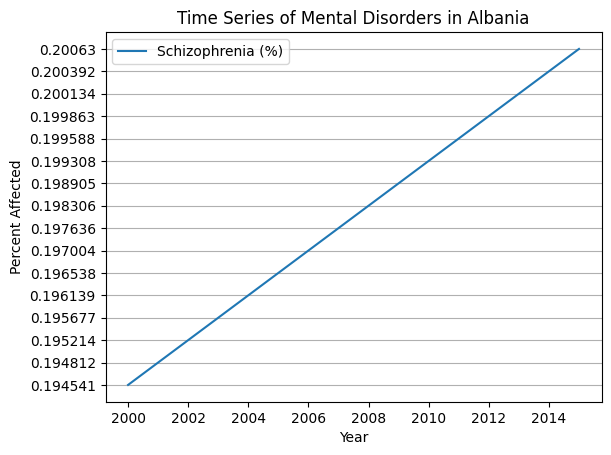

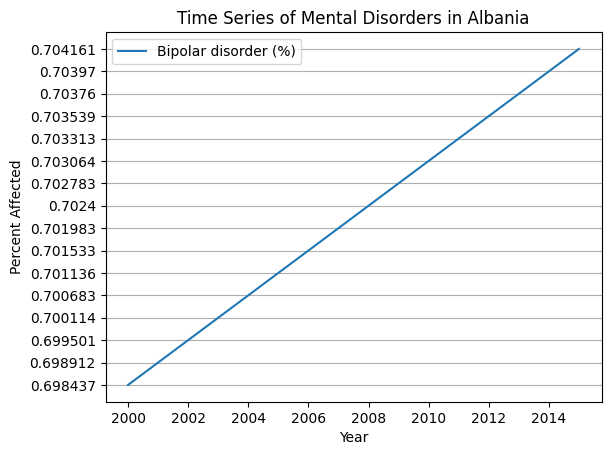

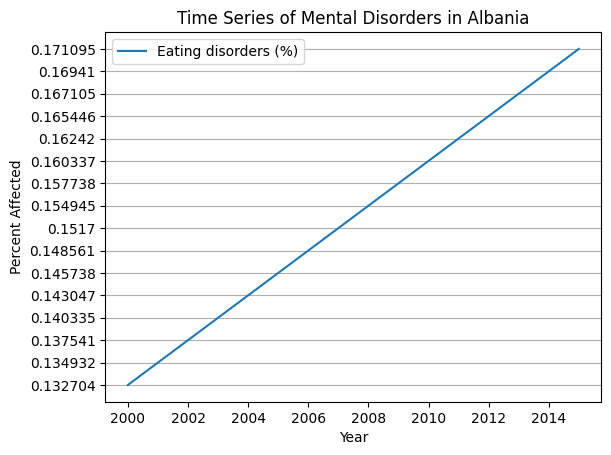

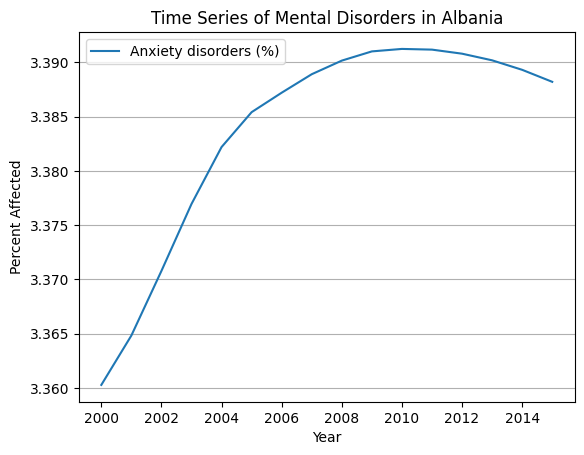

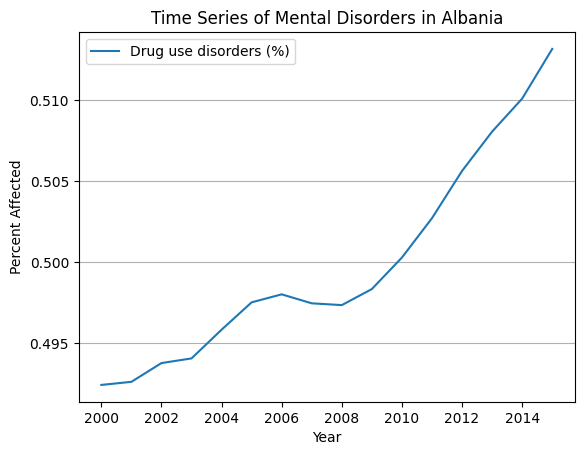

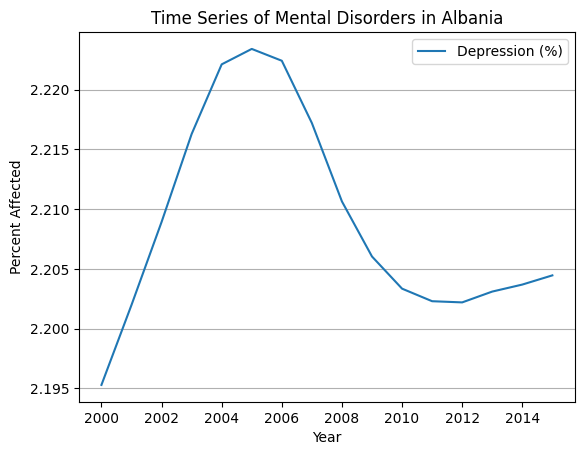

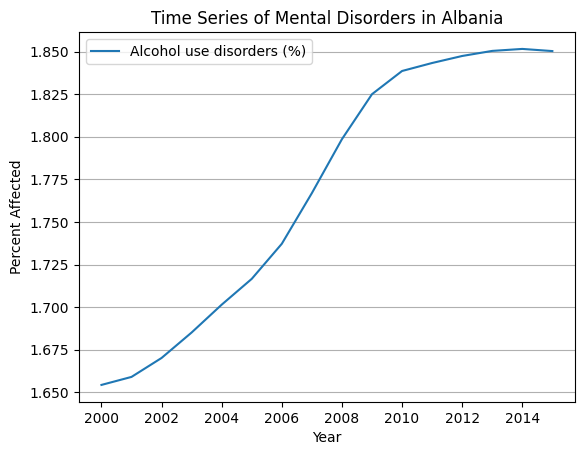

In [166]:
line_plot(final_df, 'Albania')

In [170]:
#Create a line chart that groups by mental disorders across different countries
# def line_plot(df, country):
#     country_df = df[df['Country'] == country]
    
#     for column in df.columns[2:9]:
#         plt.plot(country_df['Year'], country_df[column], label=column)
    

#     plt.xlabel('Year')
#     plt.ylabel('Percent Affected')
#     plt.title('Time Series of Mental Disorders')
#     plt.legend(loc='best')  # Add a legend
#     plt.grid(True)
#     plt.show()

max_values = final_df.iloc[:, 2:9].max(axis=1)
print(max_values)

# def line_plot(df, country):
#     country_df = df[df['Country'] == country]

#     for column in df.columns[2:9]:
#         plt.plot(country_df['Year'], country_df[column], label=column)

#     # Custom y-axis ticks and labels
#     y_ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3, ]  # Adjust these values as per your requirements
#     y_labels = ['0-0.5', '0.5-1', '1-1.5', '1.5-2', '2-2.5', '2.5-3']  # Adjust labels according to the ranges

#     plt.yticks(y_ticks, y_labels)  # Set custom y-axis ticks and labels
#     plt.xlabel('Year')
#     plt.ylabel('Percent Affected')
#     plt.title('Time Series of Mental Disorders')
#     plt.legend(loc='best')  # Add a legend
#     plt.grid(True)
#     plt.show()

TypeError: '>=' not supported between instances of 'str' and 'float'

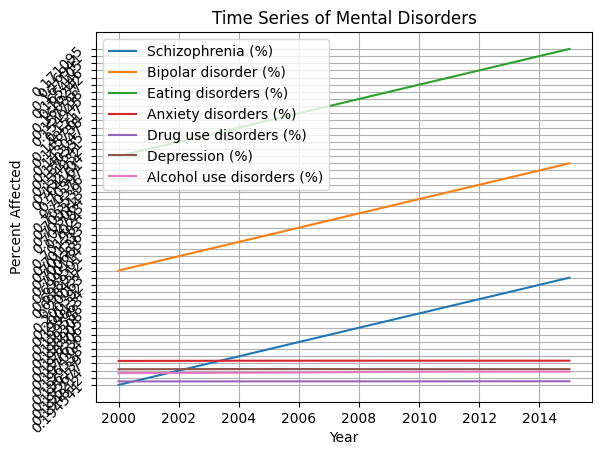

In [52]:
line_plot(global_mental_health_df, 'Albania')

In [63]:
#PCA Plots
# Standardize the data (mean=0, variance=1)
columns_for_pca = [
    'Schizophrenia (%)',
    'Bipolar disorder (%)',
    'Eating disorders (%)',
    'Anxiety disorders (%)',
    'Drug use disorders (%)',
    'Depression (%)',
    'Alcohol use disorders (%)',
]
data_for_pca = final_df[columns_for_pca]
data_for_pca = (data_for_pca - data_for_pca.mean()) / data_for_pca.std()

# Perform PCA
pca = PCA(n_components=2)  # You can adjust the number of components as needed
principal_components = pca.fit_transform(data_for_pca)

# Create a DataFrame for the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Schizophrenia (%)', 'Bipolar disorders (%)'])

# Add 'Country' column to the PCA DataFrame
pca_df['Country'] = final_df['Country']

# Create a PCA plot
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['Schizophrenia (%)'], pca_df['Bipolar disorders (%)'])

# Annotate points with country names
for i, country in enumerate(pca_df['Country']):
    plt.annotate(country, (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Mental Disorder Data')
plt.grid()
plt.show()

KeyError: 'Country'